# AUTOENCODERS

testing AE on mnist dataset

In [ ]:
!pip install torch
!pip install torchvision

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
# Get cpu, gpu or mps device for training.

# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 32,
                                     shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 71189701.67it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 78761829.53it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29213641.40it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19927331.35it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# show images
train_features, train_labels = next(iter(loader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


In [ ]:
img = train_features[0].squeeze()
label = train_labels[0]

print(f"image shape: {img.size()}")

image shape: torch.Size([28, 28])


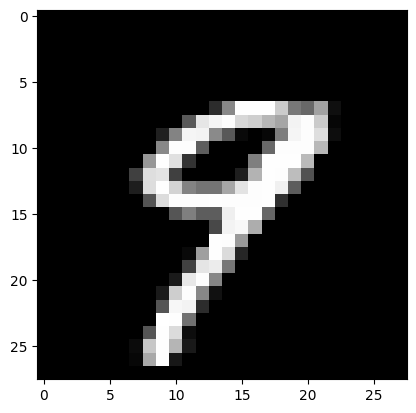

Label: 9


In [ ]:
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Create Autoencoder Class

In this coding snippet, the encoder section reduces the dimensionality of the data sequentially as given by:

28*28 = 784 ==> 128 ==> 64 ==> 36 ==> 18 ==> 9
Where the number of input nodes is 784 that are coded into 9 nodes in the latent space. Whereas, in the decoder section, the dimensionality of the data is linearly increased to the original input size, in order to reconstruct the input.

9 ==> 18 ==> 36 ==> 64 ==> 128 ==> 784 ==> 28*28 = 784
Where the input is the 9-node latent space representation and the output is the 28*28 reconstructed input.

The encoder starts with 28*28 nodes in a Linear layer followed by a ReLU layer, and it goes on until the dimensionality is reduced to 9 nodes. The decryptor uses these 9 data representations to bring back the original image by using the inverse of the encoder architecture. The decryptor architecture uses a Sigmoid Layer to range the values between 0 and 1 only.

In [ ]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128*2*2),
            torch.nn.ReLU(),
            torch.nn.Linear(128*2*2, 128*2),
            torch.nn.ReLU(),
            torch.nn.Linear(128*2, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32)
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128*2),
            torch.nn.ReLU(),
            torch.nn.Linear(128*2, 128*2*2),
            torch.nn.ReLU(),
            torch.nn.Linear(128*2*2, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Initializing Model

We validate the model using the Mean Squared Error function, and we use an Adam Optimizer with a learning rate of 0.1 and weight decay of 10^{-8}

In [ ]:
# Model Initialization
model = AE().to(device)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.01
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.001)

## Create Output Generation

The output against each epoch is computed by passing as a parameter into the Model() class and the final tensor is stored in an output list. The image into (-1, 784) and is passed as a parameter to the Autoencoder class, which in turn returns a reconstructed image. The loss function is calculated using MSELoss function and plotted. In the optimizer, the initial gradient values are made to zero using zero_grad(). loss.backward() computes the grad values and stored. Using the step() function, the optimizer is updated.

The original image and the reconstructed image from the outputs list are detached and transformed into a NumPy Array for plotting the images.

Note: This snippet takes 15 to 20 mins to execute, depending on the processor type. Initialize epoch = 1, for quick results. Use a GPU/TPU runtime for faster computations.

In [ ]:
import time
import numpy as np


epochs = 20
outputs = []
losses = []


dur = []
training_start_time = time.time()

for epoch in range(epochs):

    t0 = time.time()
    for (image, _) in loader:

      # Reshaping the image to (-1, 784)
      image = image.reshape(-1, 28*28).to(device)

      # Output of Autoencoder
      reconstructed = model(image)

      # Calculating the loss function
      loss = loss_function(reconstructed, image)

      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Storing the losses in a list for plotting
      losses.append(loss)
    outputs.append((epochs, image, reconstructed))
    dur.append(time.time() - t0)
    print('Epoch: {:03d}, Loss: {:.4f}, Time(s) {:.4f}'.format(epoch,loss, np.mean(dur)))

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

Epoch: 000, Loss: 0.0327, Time(s) 19.0996
Epoch: 001, Loss: 0.0218, Time(s) 18.3977
Epoch: 002, Loss: 0.0174, Time(s) 18.2685
Epoch: 003, Loss: 0.0212, Time(s) 17.9957
Epoch: 004, Loss: 0.0187, Time(s) 17.9490
Epoch: 005, Loss: 0.0153, Time(s) 17.7968
Epoch: 006, Loss: 0.0148, Time(s) 17.7591
Epoch: 007, Loss: 0.0145, Time(s) 17.6840
Epoch: 008, Loss: 0.0155, Time(s) 17.6240
Epoch: 009, Loss: 0.0178, Time(s) 17.6371
Epoch: 010, Loss: 0.0171, Time(s) 17.6745
Epoch: 011, Loss: 0.0138, Time(s) 17.6419
Epoch: 012, Loss: 0.0123, Time(s) 17.6576
Epoch: 013, Loss: 0.0121, Time(s) 17.6139
Epoch: 014, Loss: 0.0110, Time(s) 17.6086
Epoch: 015, Loss: 0.0114, Time(s) 17.4746
Epoch: 016, Loss: 0.0121, Time(s) 17.2273
Epoch: 017, Loss: 0.0113, Time(s) 16.9587
Epoch: 018, Loss: 0.0115, Time(s) 16.7112
Epoch: 019, Loss: 0.0114, Time(s) 16.4740
Training finished, took 329.49s


In [ ]:
losses = [loss.cpu().detach().numpy()  for loss in losses]

In [ ]:
print(losses)

[array(0.23160599, dtype=float32), array(0.30846128, dtype=float32), array(0.84247494, dtype=float32), array(0.8650187, dtype=float32), array(0.84741575, dtype=float32), array(0.84111077, dtype=float32), array(0.85449153, dtype=float32), array(0.837618, dtype=float32), array(0.8488205, dtype=float32), array(0.8316155, dtype=float32), array(0.8546522, dtype=float32), array(0.8496997, dtype=float32), array(0.8523556, dtype=float32), array(0.8429759, dtype=float32), array(0.8410869, dtype=float32), array(0.8398596, dtype=float32), array(0.84098434, dtype=float32), array(0.8536109, dtype=float32), array(0.85966545, dtype=float32), array(0.8378548, dtype=float32), array(0.8618043, dtype=float32), array(0.84394544, dtype=float32), array(0.856691, dtype=float32), array(0.84730035, dtype=float32), array(0.84756124, dtype=float32), array(0.8507314, dtype=float32), array(0.83749604, dtype=float32), array(0.84009886, dtype=float32), array(0.84830886, dtype=float32), array(0.86322206, dtype=float3

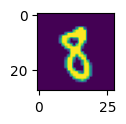

In [ ]:
for i, item in enumerate(image[:3]):
  # Reshape the array for plotting
  item = item.cpu().reshape(-1, 28, 28)
  plt.figure(figsize=(1,1))
  plt.imshow(item[0].detach().numpy())
  plt.show()


In [ ]:
reconstructed.shape

torch.Size([32, 784])

In [ ]:
for i, item in enumerate(reconstructed[:3]):
  item = item.cpu().reshape(-1, 28, 28)
  plt.figure(figsize=(1,1))
  plt.imshow(item[0].detach().numpy())
  plt.show()